In [1]:
import ee
import geemap
ee.Initialize()
geemap.set_proxy(port="7890")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geemap.chart as chart

## 1 加载相关数据

### 1.1 加载本地的长江流域shp

In [3]:
yangtzeBasin = geemap.shp_to_ee('E:/researchData/Yangtze/YangtzeBasin.shp')

In [4]:
Map = geemap.Map()
Map.centerObject(yangtzeBasin, 5)
Map.addLayer(yangtzeBasin, {}, '长江流域')
Map

Map(center=[30.23479495214304, 107.24266148024736], controls=(WidgetControl(options=['position', 'transparent_…

### 1.2 设置起止时间

In [5]:
startYear = 2018
endYear = 2022
# 为开始年份和结束年份创建两个日期对象
startDate = ee.Date.fromYMD(startYear, 1, 1)
endDate = ee.Date.fromYMD(endYear + 1, 1, 1)
# 创建一个年份列表
years = ee.List.sequence(startYear, endYear)
# 创建一个月份列表
months = ee.List.sequence(1, 12)

### 1.3 加载 CHIRPS 数据集

In [6]:
CHIRPS = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
CHIRPS = CHIRPS.filterDate(startDate, endDate)

### 1.4 加载 MODIS 地表反射率数据集

In [7]:
mod09 = ee.ImageCollection('MODIS/061/MOD09A1')
mod09 = mod09.filterDate(startDate, endDate)

In [8]:
# 利用 StateQA 波段去云、去云阴影
def noClound(image):
    quality = image.select('StateQA')
    mask = image.And(quality.bitwiseAnd(1).eq(0)) \
                .And(quality.bitwiseAnd(2).eq(0))
    return image.updateMask(mask)

In [9]:
mod09 = mod09.map(noClound)

### 1.5 加载 MOD13 数据集的 EVI 波段 

In [10]:
mod13_EVI = ee.ImageCollection('MODIS/061/MOD13A1') \
            .filterDate(startDate, endDate) \
            .select('EVI')

### 1.6 加载 MOD16 数据集的 ET 波段

In [11]:
mod16_ET = ee.ImageCollection('MODIS/006/MOD16A2') \
            .filterDate(startDate, endDate) \
            .select('ET')

## 2 计算

### 2.1 计算 MSI 指数

In [12]:
# MSI 计算函数
# 选择 NIR 和 SWIR 波段，设置时间戳并返回 MSI
def msi_caculate(image):
    nirband = image.select('sur_refl_b02')
    swirband = image.select('sur_refl_b06')
    msi = swirband.divide(nirband) \
                .rename('MSI') \
                .set('system:time_start', image.get('system:time_start'))
    return msi
# 对 mod09 图像集合进行映射
mod09_MSI = mod09.map(msi_caculate)

### 2.2 计算各个相关指标

In [13]:
# 计算各个指标
# 应用一个嵌套循环，首先在相关年份进行映射，然后在相关月份进行映射
# 该函数返回包含月度降雨量(P)、蒸散发(ET)、水量平衡(wb)、EVI 和 MSI 的5个波段图像。
def caculate_months(y):
    def caculate_all(m):
        # 计算降雨量
        P = CHIRPS.filter(ee.Filter.calendarRange(y, y, 'year')) \
                .filter(ee.Filter.calendarRange(m, m, 'month')) \
                .sum()
        # 计算 ET 蒸散，乘以0.1是因为 ET 的缩放因子
        ET = mod16_ET.filter(ee.Filter.calendarRange(y, y, 'year')) \
                .filter(ee.Filter.calendarRange(m, m, 'month')) \
                .sum() \
                .multiply(0.1)
        # 计算水平衡，乘以0.0001是因为 ET 的缩放因子
        wb = P.subtract(ET).rename('wb')
        # 计算 EVI 的平均值
        evi = mod13_EVI.filter(ee.Filter.calendarRange(y, y, 'year')) \
                .filter(ee.Filter.calendarRange(m, m, 'month')) \
                .mean() \
                .multiply(0.0001)
        # 计算 MSI 的平均值
        msi = mod09_MSI.filter(ee.Filter.calendarRange(y, y, 'year')) \
                .filter(ee.Filter.calendarRange(m, m, 'month')) \
                .mean()
        # 返回一个图像，将上面的5个图像作为5个波段
        return ee.Image.cat([P, ET, wb, evi, msi]) \
                .set('year', y) \
                .set('month', m) \
                .set('system:time_start', ee.Date.fromYMD(y, m, 1))
    return months.map(caculate_all)
# flatten() 应用于将集合的集合转换为单个集合
ic = ee.ImageCollection.fromImages(
    years.map(caculate_months).flatten()
)

## 3 月降雨量可视化

### 3.1 筛选出每月总降雨量数据

In [14]:
monthlyPrecip = ic.select('precipitation')

### 3.2 可视化月平均降水量数据

In [15]:
# 添加长江流域的月均值图层
precipVis = {
  'min': 0,
  'max': 250,
  'palette': ['white', 'blue', 'darkblue', 'red', 'purple']
}
Map.addLayer(monthlyPrecip.mean().clip(yangtzeBasin), precipVis, '月均降水')
Map

Map(center=[30.23479495214304, 107.24266148024736], controls=(WidgetControl(options=['position', 'transparent_…

### 3.3 数据导出到 Excel 表格

In [16]:
region = yangtzeBasin.geometry()

In [17]:
# 定义一个函数，用于对每个影像的降雨量波段数值求均值，
# 并返回一个包含降雨量和时间属性的Feature
def get_mean_and_date(image):
    # 对降雨量波段数值求均值，使用ee.Reducer.mean()方法，并指定区域和缩放比例
    mean = image.reduceRegion(ee.Reducer.mean(), region, 5000).get('precipitation')
    # 获取影像的日期，使用ee.Date()方法，并格式化为YYYY-MM-dd
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    # 返回一个包含降雨量和时间的要素，使用ee.Feature()方法，并设置几何和属性
    return ee.Feature(None, {'date': date, 'precip_mean': mean})

# 使用ee.ImageCollection.map()方法来对影像集合中每个影像应用上面定义的函数
# map()函数返回的是一个ee.ComputedObject类型的对象
# 需要将结果转化为ee.FeatureCollection
precip_mean = ee.FeatureCollection(monthlyPrecip.map(get_mean_and_date))

In [18]:
df = geemap.ee_to_pandas(precip_mean)
df

,date,precip_mean
0,2018-01-01,40.309685
1,2018-02-01,30.985813
2,2018-03-01,73.024214
3,2018-04-01,85.645445
4,2018-05-01,151.251975
5,2018-06-01,157.225485
6,2018-07-01,195.406190
7,2018-08-01,154.987339
8,2018-09-01,140.872965
9,2018-10-01,61.716865


In [19]:
%pip install openpyxl

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [20]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
precip_output = './output/yangtze_precip_chart_monthly(2018~2022).xlsx'
df.to_excel(precip_output, index=False)

### 3.4 绘制直方图

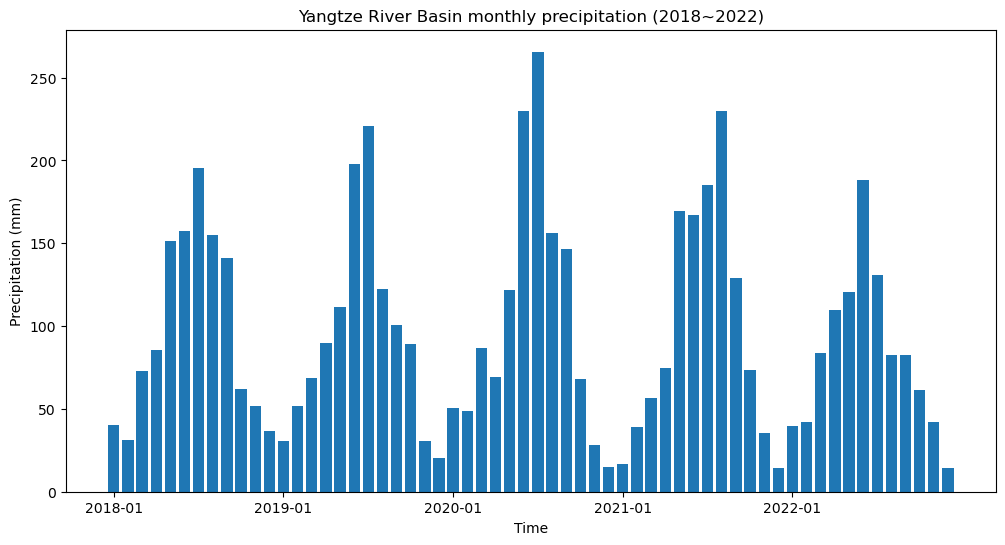

In [21]:
df = pd.read_excel(precip_output)
# 设置图形的大小
plt.figure(figsize=(12, 6))

# 将date读取为只显示年份-月份的形式
df['date'] = df['date'].dt.strftime('%Y-%m')

# 绘制柱状图，使用日期作为x轴，平均降水量作为y轴
plt.bar(df['date'], df['precip_mean'])

# 设置x轴的刻度，每隔1年(12个日期)显示一个标签
plt.xticks(np.arange(0, len(df), 12))

# 设置x轴和y轴的标签
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')

# 设置图形的标题
plt.title('Yangtze River Basin monthly precipitation (2018~2022)')

# 显示图形
plt.show()

## 4 月蒸散发可视化

### 4.1 筛选出每月总蒸散发量数据

In [22]:
monthlyEvap = ic.select('ET')

### 4.2 地图可视化

In [23]:
evapVis = {
    'min': 0,
    'max': 140,
    'palette': ['red', 'orange', 'yellow', 'blue', 'darkblue']
}
Map.addLayer(monthlyEvap.mean().clip(yangtzeBasin), evapVis, '月均蒸散发')
Map

Map(center=[30.23479495214304, 107.24266148024736], controls=(WidgetControl(options=['position', 'transparent_…

### 4.3 数据导出

In [24]:
# 定义一个函数，用于对每个影像的月蒸散发量波段数值求均值，
# 并返回一个包含月蒸散发和时间属性的Feature
def get_ET_mean_date(image):
    # 对月蒸散发量波段数值求均值，分辨率为500米
    mean = image.reduceRegion(ee.Reducer.mean(), region, 500).get('ET')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    # 返回一个包含月蒸散发量和时间的要素
    return ee.Feature(None, {'date': date, 'ET_mean': mean})

evap_mean = ee.FeatureCollection(monthlyEvap.map(get_ET_mean_date))

In [25]:
df = geemap.ee_to_pandas(evap_mean)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
ET_output = './output/yangtze_evap_chart_monthly(2018~2022).xlsx'
df.to_excel(ET_output, index=False)

### 4.4 绘制直方图

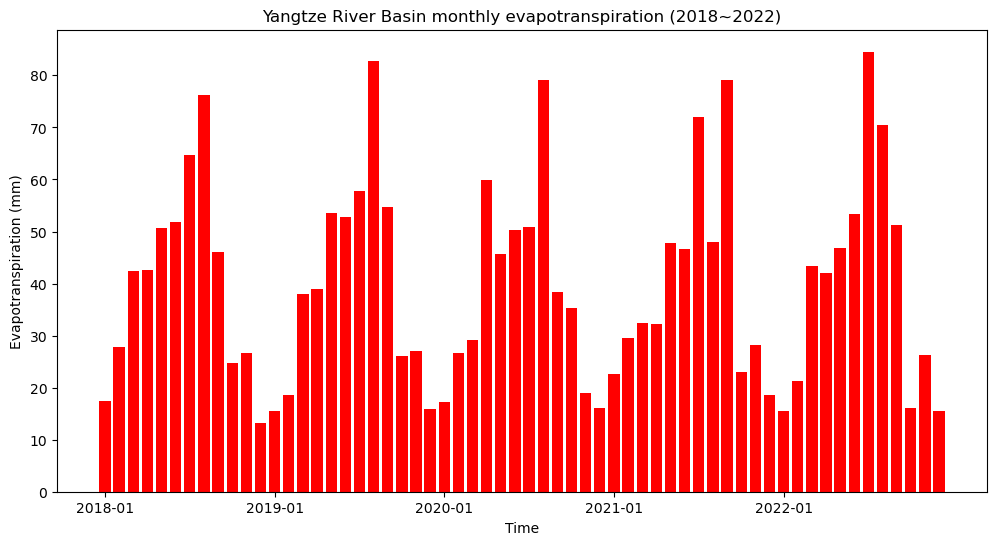

In [26]:
df = pd.read_excel(ET_output)

plt.figure(figsize=(12, 6))
df['date'] = df['date'].dt.strftime('%Y-%m')
# 绘制柱状图，使用日期作为x轴，平均蒸发散量作为y轴，柱状图红色
plt.bar(df['date'], df['ET_mean'], color='red')
plt.xticks(np.arange(0, len(df), 12))
plt.xlabel('Time')
plt.ylabel('Evapotranspiration (mm)')
plt.title('Yangtze River Basin monthly evapotranspiration (2018~2022)')
plt.show()

## 5 月度水量平衡

### 5.1 筛选出每月水量平衡数据

In [27]:
waterBalance = ic.select('wb')

### 5.2 地图可视化

In [28]:
balanceVis = {
    'min': -50,
    'max': 200,
    'palette': ['red', 'orange', 'yellow', 'blue', 'darkblue', 'purple']
}
Map.addLayer(waterBalance.mean().clip(yangtzeBasin), balanceVis, '月均水量平衡')

### 5.3 数据导出

In [29]:
# 定义一个函数，用于对每个影像的水量平衡波段数值求均值，
# 并返回一个包含水量平衡数据和时间属性的Feature
def get_balance_mean_date(image):
    # 对月蒸散发量波段数值求均值，分辨率为500米
    mean = image.reduceRegion(ee.Reducer.mean(), region, 500).get('wb')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'balance_mean': mean})

balance_mean = ee.FeatureCollection(waterBalance.map(get_balance_mean_date))

In [30]:
df = geemap.ee_to_pandas(balance_mean)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
WB_output = './output/yangtze_balance_chart_monthly(2018~2022).xlsx'
df.to_excel(WB_output, index=False)

### 5.4 绘制图表

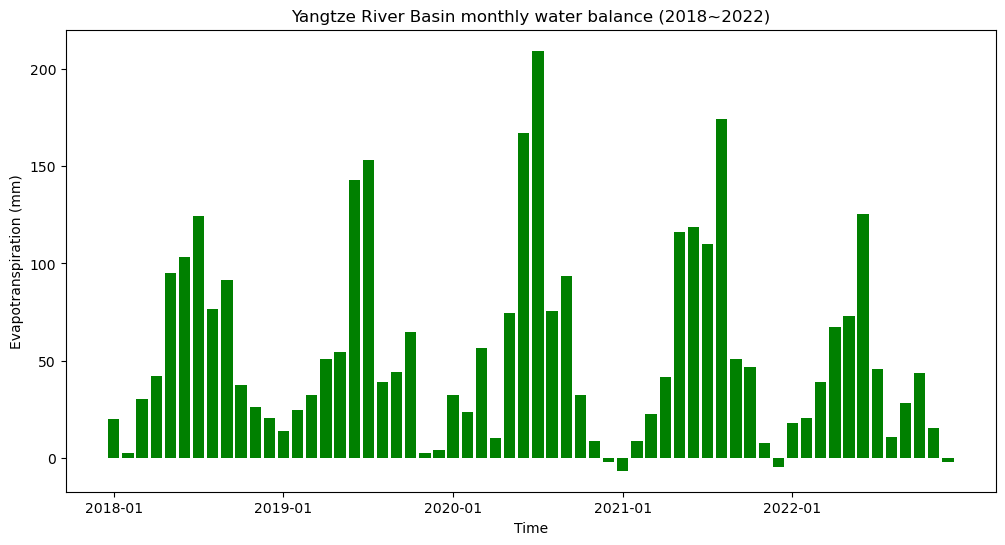

In [31]:
df = pd.read_excel(WB_output)

plt.figure(figsize=(12, 6))
df['date'] = df['date'].dt.strftime('%Y-%m')
# 绘制柱状图，使用日期作为x轴，平均蒸发散量作为y轴，柱状图绿色
plt.bar(df['date'], df['balance_mean'], color='green')
plt.xticks(np.arange(0, len(df), 12))
plt.xlabel('Time')
plt.ylabel('Evapotranspiration (mm)')
plt.title('Yangtze River Basin monthly water balance (2018~2022)')
plt.show()

### 5.5 绘制降水、蒸散发、水平衡对比曲线图

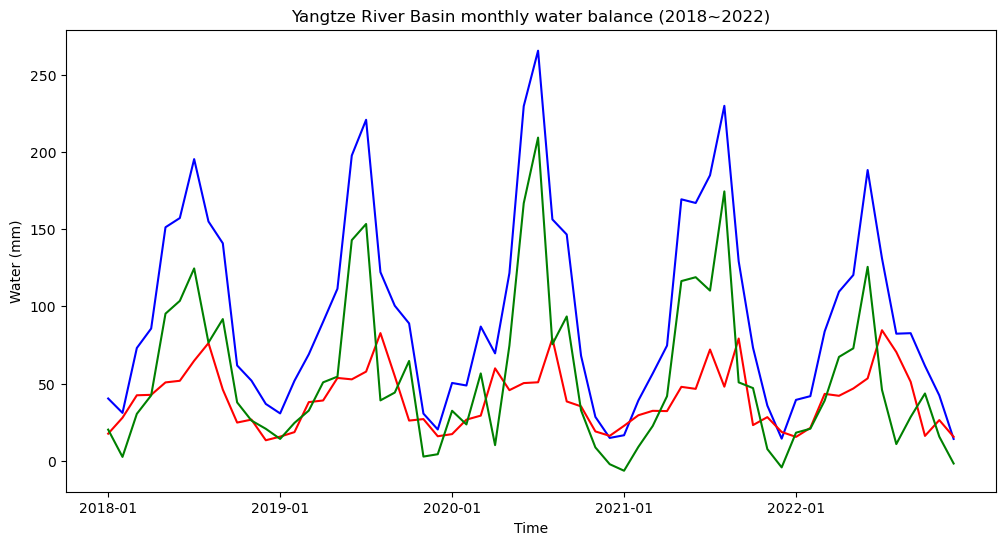

In [32]:
Precip_df = pd.read_excel(precip_output)
ET_df = pd.read_excel(ET_output)
WB_df = pd.read_excel(WB_output)

plt.figure(figsize=(12, 6))
Precip_df['date'] = Precip_df['date'].dt.strftime('%Y-%m')
ET_df['date'] = ET_df['date'].dt.strftime('%Y-%m')
WB_df['date'] = WB_df['date'].dt.strftime('%Y-%m')

# 绘制曲线图，使用日期作为x轴，平均蒸发散量作为y轴
plt.plot(Precip_df['date'], Precip_df['precip_mean'], label='Precip', color='blue')
plt.plot(ET_df['date'], ET_df['ET_mean'], label='ET', color='red')
plt.plot(WB_df['date'], WB_df['balance_mean'], label='WB', color='green')
plt.xticks(np.arange(0, len(df), 12))
plt.xlabel('Time')
plt.ylabel('Water (mm)')
plt.title('Yangtze River Basin monthly water balance (2018~2022)')
plt.show()

## 6 区域干旱程度可视化

### 6.1 筛选出月平均 EVI 和 MSI 数据

In [33]:
EVI = ic.select('EVI')
MSI = ic.select('MSI')

In [34]:
ic.first().bandNames().getInfo()

['precipitation', 'ET', 'wb', 'EVI', 'MSI']

### 6.2 地图可视化

In [35]:
eviVis = {
    'min': 0,
    'max': 0.7,
    'palette': ['red', 'orange', 'yellow', 'green', 'darkgreen']
}
Map.addLayer(EVI.mean().clip(yangtzeBasin), eviVis, 'EVI')
msiVis = {
    'min': 0.25,
    'max': 1,
    'palette': ['darkblue', 'blue', 'yellow', 'orange', 'red']
}
Map.addLayer(MSI.mean().clip(yangtzeBasin), msiVis, 'MSI')
Map

Map(center=[30.23479495214304, 107.24266148024736], controls=(WidgetControl(options=['position', 'transparent_…

### 6.3 导出指数计算数据

In [36]:
def get_msi_mean_date(image):
    mean = image.reduceRegion(ee.Reducer.mean(), region, 5000).get('MSI')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'msi_mean': mean})

MSI_mean = ee.FeatureCollection(MSI.map(get_msi_mean_date))

In [37]:
df = geemap.ee_to_pandas(MSI_mean)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
MSI_output = './output/yangtze_msi_chart_monthly(2018~2022).xlsx'
df.to_excel(MSI_output, index=False)

In [38]:
def get_evi_mean_date(image):
    mean = image.reduceRegion(ee.Reducer.mean(), region, 5000).get('EVI')
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'evi_mean': mean})

EVI_mean = ee.FeatureCollection(EVI.map(get_evi_mean_date))

In [39]:
df = geemap.ee_to_pandas(EVI_mean)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
EVI_output = './output/yangtze_evi_chart_monthly(2018~2022).xlsx'
df.to_excel(EVI_output, index=False)

### 6.4 绘制指数图表

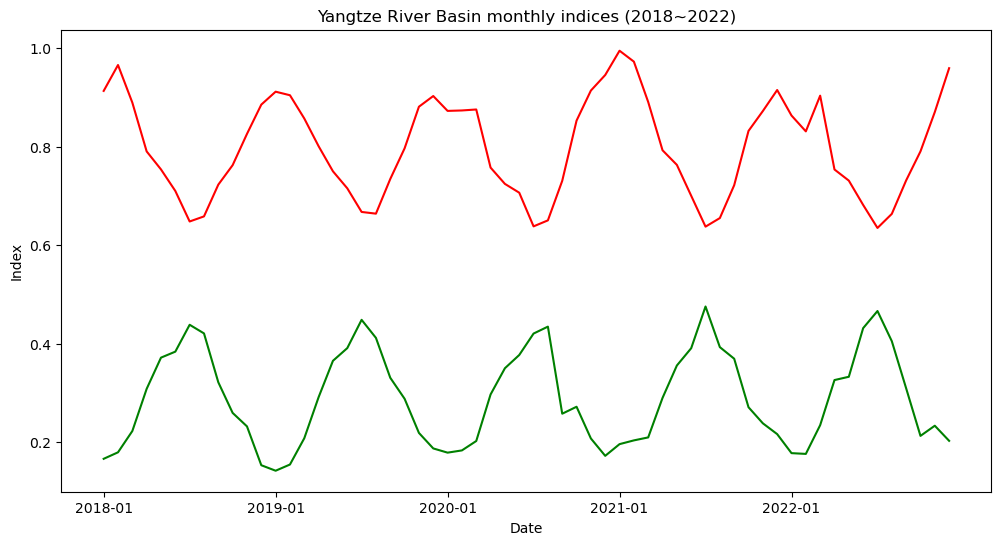

In [40]:
MSI_df = pd.read_excel(MSI_output)
EVI_df = pd.read_excel(EVI_output)

plt.figure(figsize=(12, 6))
MSI_df['date'] = MSI_df['date'].dt.strftime('%Y-%m')
EVI_df['date'] = EVI_df['date'].dt.strftime('%Y-%m')

# 绘制曲线图，使用日期作为x轴，平均蒸发散量作为y轴
plt.plot(MSI_df['date'], MSI_df['msi_mean'], label='MSI', color='red')
plt.plot(EVI_df['date'], EVI_df['evi_mean'], label='EVI', color='green')
plt.xticks(np.arange(0, len(df), 12))
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Yangtze River Basin monthly indices (2018~2022)')
plt.show()